# Solution for qualification problem number 2 for ICM workshop in Jan 2017, by Grzegorz Uriasz

In this solution I will show 3 diffrent architectures for solving this problem. To determine which will be the most accurate approach each model is build from scratch and then the training process consists of the same number of epochs and the same optimizer to ensure that the diffrences are not caused by longer training times or better training methods.

In [1]:
#Importing and preconfiguration of neccesary modules
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout

from keras.utils import np_utils
from scipy import io
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
import pandas as pd

import os
import sys
import time

#for displaying keras model visualizations
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

from keras_ascii_sequential import sequential_model_to_ascii_printout

Using Theano backend.


In [2]:
#loading notMNIST datasheet from http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html
if(not os.path.isfile("./notMNIST_small.mat")):
    #get the dataset
    sys.stdout.write(b"Fetching the dataset from the internet")
    import requests
    s = requests.Session()
    while(True):
        r = s.get("http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat", stream="True")
        if(r.status_code == 200):
            f = open("./notMNIST_small.mat", 'wb')
            for chunk in r.iter_content(chunk_size=512 * 1024): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    sys.stdout.write(b".")
                    sys.stdout.flush()
            f.close()
            print("Done")
            break
        os.sleep(200) #do not dos the server :)
    del s #close sesion
    del requests
    
data = io.loadmat("./notMNIST_small.mat")

#preparation of the data
X = data['images']
y = data['labels']
resolution = 28
classes = 10

X = np.transpose(X, (2, 0, 1))

y = y.astype('int32')
X = X.astype('float32') / 255.

Y = np_utils.to_categorical(y,10)

In [3]:
#Generation of the training and test set
#Let the seed for the RNG be the most random number in the world - https://xkcd.com/221/
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4)

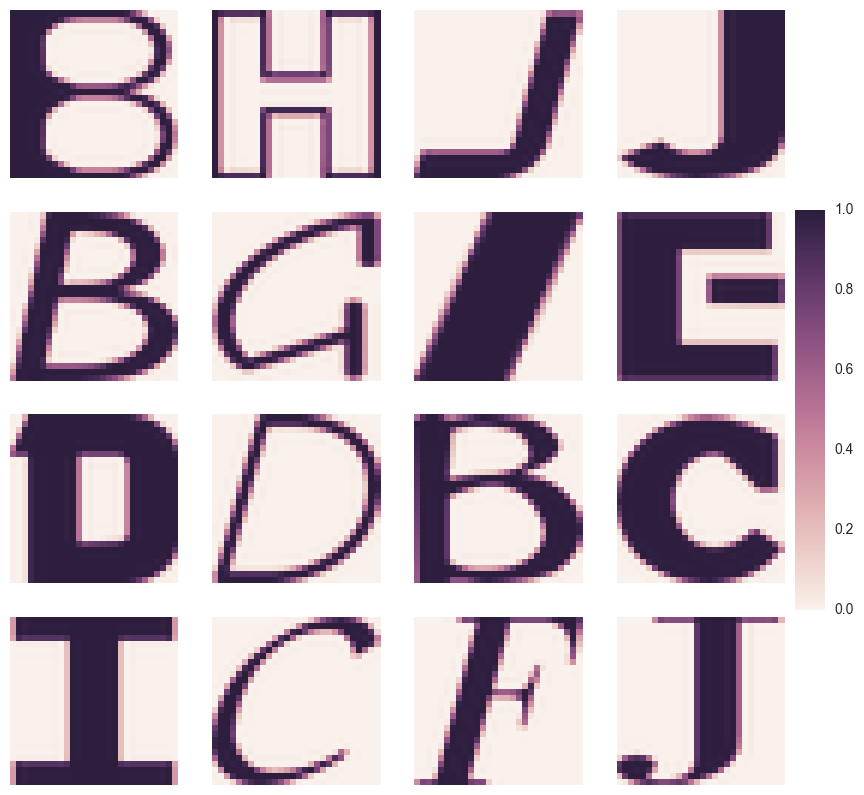

In [4]:
#Plot some of the test data
np.random.seed(4) #again the same seed
plt.rcParams['figure.figsize'] = (10,10)
fig, axn = plt.subplots(4, 4, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
X_test_len = len(X_test)
for i, ax in enumerate(axn.flat):
    sns.heatmap(X_test[np.random.randint(0, X_test_len)], ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1,
                cbar_ax=None if i else cbar_ax,
               xticklabels=False, yticklabels=False)

### After the datasets are prepared I made a function to train and analyze the performance of a given model

In [115]:
batch_size = 32
nb_epoch = 10
optimizer = "adam"
def TrainAndAnalyze(model=None, train_data=None, test_data=None, trained=False, save_filename=None):
    if not trained:
        #compile the model
        #model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        #train the model using 20 epochs
        history = model.fit(train_data[0], train_data[1], nb_epoch=nb_epoch, batch_size=batch_size, validation_data=test_data)
        
        #plot loss over epoch on the training and testing data
        plt.rcParams['figure.figsize'] = (10,5)
        fig, axn = plt.subplots(1, 2, sharex=True, sharey=True)
        history.history['epoch'] = range(1,nb_epoch+1)
        sns.regplot('epoch', 'loss', data=pd.DataFrame(history.history), fit_reg=False, ax=axn.flat[0])
        sns.regplot('epoch', 'val_loss', data=pd.DataFrame(history.history), fit_reg=False, ax=axn.flat[1])
        plt.show()
        
        #save the model to a file for further use
        while(os.path.isfile(save_filename)):  #make sure we dont overwrite another model
            save_filename = save_filename[:-3]+str(time.time())+".h5"
        model.save(save_filename)
    else:
        #Find the accuracy of the model
        score = model.evaluate(test_data[0], test_data[1], batch_size=batch_size)
        print("\nThis model obtained %.02lf%% accuracy on the test data"%(score[1]*100))
        
        #Calculate advanced fail statistics
        predictions = model.predict_classes(test_data[0])
        print("")
        
        fail_data = {}
        num_of_examples = np.zeros(10)
        for i in range(0,10):
            fail_data[i] = np.zeros(10)
        for i,j in zip(predictions, test_data[1]):
            number = np.nonzero(j)[0][0]
            fail_data[number][i] += 1
            
        #Calculate what are the probalilities that a number had been mistaken for another number
        for i in range(0,10):
            num_of_examples[i] = np.sum(fail_data[i])
            if(fail_data[i][i] == num_of_examples[i]):
                print ("Number %d hadn't been mistaken for another number."%(i))
                print("------------------------------\n")
                continue
            fail_data[i][i] = 0
            fail_data[i] = fail_data[i].astype(np.float32) / num_of_examples[i]
            sys.stdout.write(b"Number %d had been mostly mistaken for:\n"%(i))
            for number in (np.argwhere(fail_data[i] == np.amax(fail_data[i])).flatten()):
                sys.stdout.write("\tNumber %d(that mistake happened in %.02lf%% of predictions)\n"%(number, 100*fail_data[i][number]))
            print("------------------------------\n")
        
       

### And a function for visualizing a given model

In [112]:
def VisualizeModel(model = None):
    SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
    sequential_model_to_ascii_printout(model)

## Now that we prepared the necessary tools let's look at some models

## First let's look at a simple feedforward neural network

In [127]:
model = Sequential()
model.add(Flatten(input_shape=(resolution, resolution)))
model.add(Dense(resolution*resolution))
model.add(Activation(activation="relu"))
model.add(Dense(resolution*resolution))
model.add(Activation(activation="sigmoid"))

model.add(Dropout(0.3)) #to prevent overfitting

model.add(Dense(classes))
model.add(Activation(activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Train on 14979 samples, validate on 3745 samples
Epoch 1/10
14979/14979 [==============================] - 59s - loss: 0.4918 - acc: 0.8547 - val_loss: 0.3868 - val_acc: 0.8879   64/14979 [..............................] - ETA: 53s - loss: 2.3391 - acc: 0.2188

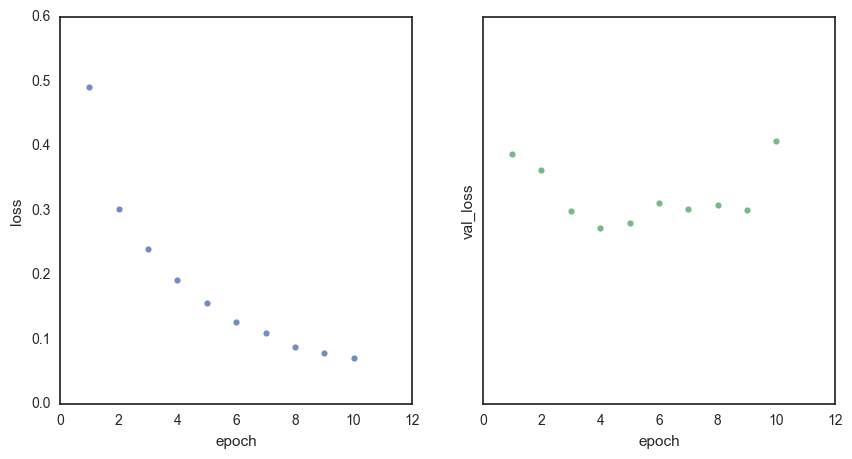

In [128]:
TrainAndAnalyze(model, (X_train, Y_train), (X_test, Y_test), False, 'simple_feed_forward.h5')

In [64]:
np.zeros(10)


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [33]:
Y_train[1]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.])

In [47]:
outs = model.predict_classes(X_test, batch_size=32)

3744/3745 [============================>.] - ETA: 0s  64/3745 [..............................] - ETA: 3s

In [50]:
outs[1]


4